In [119]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_curve, auc, roc_auc_score
)
from sklearn.preprocessing import StandardScaler, label_binarize, LabelEncoder
import warnings
warnings.filterwarnings('ignore')

# Налаштування для візуалізації
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

print("✅ Усі бібліотеки успішно завантажено!")


✅ Усі бібліотеки успішно завантажено!


## Частина 1: Завантаження та Дослідження Даних

Використаємо датасет Coffee & Health для класифікації рівня проблем зі здоров'ям на основі споживання кави та способу життя.


In [120]:
# Завантаження датасету Coffee & Health
df_raw = pd.read_csv('synthetic_coffee_health_10000.csv')

# Обробка пропущених значень у Health_Issues (NaN = 'None')
df_raw['Health_Issues'] = df_raw['Health_Issues'].fillna('None')

# Підготовка даних
# Кодування категоріальних змінних
label_encoders = {}
categorical_columns = ['Gender', 'Country', 'Sleep_Quality', 'Stress_Level', 'Health_Issues', 'Occupation']

df = df_raw.copy()
for col in categorical_columns:
    if col != 'Health_Issues':  # Health_Issues - це наша цільова змінна
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col])
        label_encoders[col] = le

# Видалення ID колонки
df = df.drop('ID', axis=1)

# Створення списку ознак (без цільової змінної)
feature_names = [col for col in df.columns if col != 'Health_Issues']

# Цільова змінна
target_names = sorted(df['Health_Issues'].unique())
target_encoder = LabelEncoder()
df['target'] = target_encoder.fit_transform(df['Health_Issues'])

print("📊 Інформація про датасет:")
print(f"Розмір датасету: {df.shape}")
print(f"\nКласи: {target_names}")
print(f"\nКількість ознак: {len(feature_names)}")
print(f"Ознаки: {feature_names}")

📊 Інформація про датасет:
Розмір датасету: (10000, 16)

Класи: ['Mild', 'Moderate', 'None', 'Severe']

Кількість ознак: 14
Ознаки: ['Age', 'Gender', 'Country', 'Coffee_Intake', 'Caffeine_mg', 'Sleep_Hours', 'Sleep_Quality', 'BMI', 'Heart_Rate', 'Stress_Level', 'Physical_Activity_Hours', 'Occupation', 'Smoking', 'Alcohol_Consumption']


In [121]:
# Статистичний огляд даних
print("📈 Статистичний опис:")
display(df.describe())

# Перевірка на пропущені значення
print("\n🔍 Пропущені значення:")
print(df.isnull().sum())

# Розподіл класів
print("\n📊 Розподіл класів:")
print(df['target'].value_counts())
print(f"\nБалансованість класів:\n{df['target'].value_counts(normalize=True) * 100}")


📈 Статистичний опис:


,Age,Gender,Country,Coffee_Intake,Caffeine_mg,Sleep_Hours,Sleep_Quality,BMI,Heart_Rate,Stress_Level,Physical_Activity_Hours,Occupation,Smoking,Alcohol_Consumption,target
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.00000,10000.00000,10000.000000,10000.000000
mean,34.949100,0.522500,9.466800,2.509230,238.411010,6.636220,1.620700,23.986860,70.617800,1.108900,7.48704,1.98920,0.20040,0.300700,1.239600
std,11.160939,0.542884,5.740086,1.450248,137.748815,1.222055,0.835525,3.906411,9.822951,0.537838,4.31518,1.40566,0.40032,0.458585,0.949464
min,18.000000,0.000000,0.000000,0.000000,0.000000,3.000000,0.000000,15.000000,50.000000,0.000000,0.00000,0.00000,0.00000,0.000000,0.000000
25%,26.000000,0.000000,4.000000,1.500000,138.750000,5.800000,1.000000,21.300000,64.000000,1.000000,3.70000,1.00000,0.00000,0.000000,0.000000
50%,34.000000,0.000000,9.000000,2.500000,235.400000,6.600000,2.000000,24.000000,71.000000,1.000000,7.50000,2.00000,0.00000,0.000000,2.000000
75%,43.000000,1.000000,14.000000,3.500000,332.025000,7.500000,2.000000,26.600000,77.000000,1.000000,11.20000,3.00000,0.00000,1.000000,2.000000
max,80.000000,2.000000,19.000000,8.200000,780.300000,10.000000,3.000000,38.200000,109.000000,2.000000,15.00000,4.00000,1.00000,1.000000,3.000000



🔍 Пропущені значення:
Age                        0
Gender                     0
Country                    0
Coffee_Intake              0
Caffeine_mg                0
Sleep_Hours                0
Sleep_Quality              0
BMI                        0
Heart_Rate                 0
Stress_Level               0
Physical_Activity_Hours    0
Health_Issues              0
Occupation                 0
Smoking                    0
Alcohol_Consumption        0
target                     0
dtype: int64

📊 Розподіл класів:
target
2    5941
0    3579
1     463
3      17
Name: count, dtype: int64

Балансованість класів:
target
2    59.41
0    35.79
1     4.63
3     0.17
Name: proportion, dtype: float64


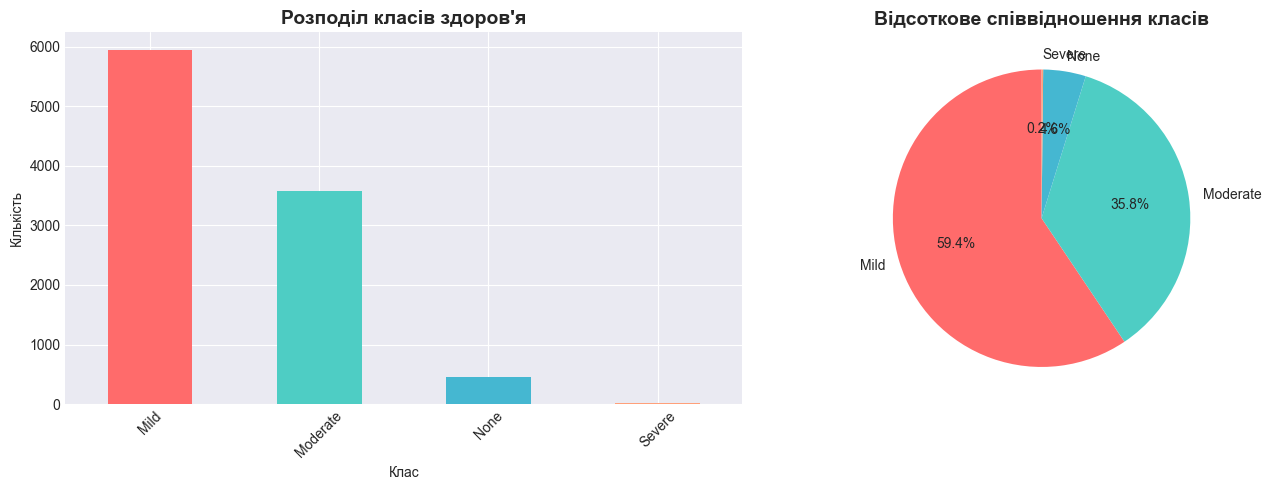

In [122]:
# Візуалізація розподілу класів
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Діаграма розподілу
df['target'].value_counts().plot(kind='bar', ax=axes[0], color=['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A'])
axes[0].set_title('Розподіл класів здоров\'я', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Клас')
axes[0].set_ylabel('Кількість')
axes[0].set_xticklabels(target_names, rotation=45)

# Кругова діаграма
axes[1].pie(df['target'].value_counts(), labels=target_names, autopct='%1.1f%%',
            colors=['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A'], startangle=90)
axes[1].set_title('Відсоткове співвідношення класів', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()


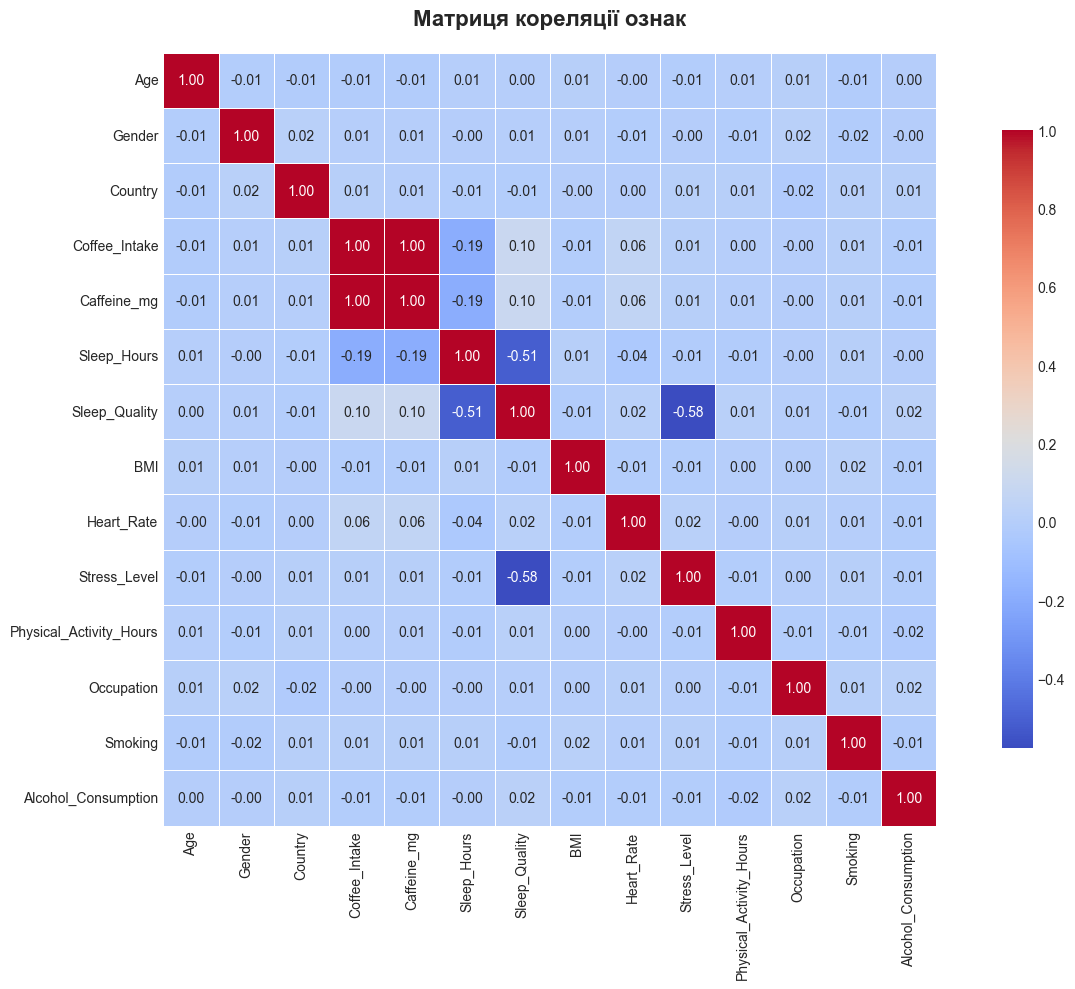


🔍 Найбільш корельовані пари ознак:
Coffee_Intake  Caffeine_mg      0.999814
Caffeine_mg    Coffee_Intake    0.999814
Stress_Level   Sleep_Quality    0.578179
Sleep_Quality  Stress_Level     0.578179
Sleep_Hours    Sleep_Quality    0.511268
Sleep_Quality  Sleep_Hours      0.511268
Sleep_Hours    Caffeine_mg      0.190493
Caffeine_mg    Sleep_Hours      0.190493
Sleep_Hours    Coffee_Intake    0.190291
Coffee_Intake  Sleep_Hours      0.190291
dtype: float64


In [123]:
# Візуалізація кореляції між ознаками
plt.figure(figsize=(14, 10))
correlation_matrix = df.drop(['target', 'Health_Issues'], axis=1).corr()
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', 
            square=True, linewidths=0.5, cbar_kws={"shrink": 0.8})
plt.title('Матриця кореляції ознак', fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

print("\n🔍 Найбільш корельовані пари ознак:")
corr_pairs = correlation_matrix.abs().unstack()
corr_pairs = corr_pairs[corr_pairs < 1.0].sort_values(ascending=False)
print(corr_pairs.head(10))


## Частина 2: Підготовка Даних


In [125]:
# Розділення на ознаки та цільову змінну
X = df.drop(['target', 'Health_Issues'], axis=1)
y = df['target']

# Розділення на тренувальну та тестову вибірки
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

print("✅ Дані розділено:")
print(f"Тренувальна вибірка: {X_train.shape}")
print(f"Тестова вибірка: {X_test.shape}")
print(f"\nРозподіл класів у тренувальній вибірці:\n{pd.Series(y_train).value_counts()}")
print(f"\nРозподіл класів у тестовій вибірці:\n{pd.Series(y_test).value_counts()}")


✅ Дані розділено:
Тренувальна вибірка: (7000, 14)
Тестова вибірка: (3000, 14)

Розподіл класів у тренувальній вибірці:
target
2    4159
0    2505
1     324
3      12
Name: count, dtype: int64

Розподіл класів у тестовій вибірці:
target
2    1782
0    1074
1     139
3       5
Name: count, dtype: int64


In [126]:
# Нормалізація даних (опціонально для дерев, але корисно для порівняння)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("✅ Дані нормалізовано")
print(f"\nСередні значення після нормалізації: {X_train_scaled.mean(axis=0)[:5]}")
print(f"Стандартні відхилення після нормалізації: {X_train_scaled.std(axis=0)[:5]}")


✅ Дані нормалізовано

Середні значення після нормалізації: [2.11132699e-16 3.04518315e-17 7.15618041e-17 1.70530257e-16
 1.49213975e-16]
Стандартні відхилення після нормалізації: [1. 1. 1. 1. 1.]


## Частина 3: Базова Модель Дерева Рішень

Спочатку створимо просту модель з параметрами за замовчуванням.


In [127]:
# Створення базової моделі
dt_basic = DecisionTreeClassifier(random_state=42)
dt_basic.fit(X_train, y_train)

# Прогнозування
y_pred_basic = dt_basic.predict(X_test)

# Оцінка моделі
print("📊 Базова модель дерева рішень:")
print(f"\nТочність (Accuracy): {accuracy_score(y_test, y_pred_basic):.4f}")
print(f"Точність (Precision): {precision_score(y_test, y_pred_basic, average='weighted'):.4f}")
print(f"Повнота (Recall): {recall_score(y_test, y_pred_basic, average='weighted'):.4f}")
print(f"F1-міра: {f1_score(y_test, y_pred_basic, average='weighted'):.4f}")

print(f"\nГлибина дерева: {dt_basic.get_depth()}")
print(f"Кількість листів: {dt_basic.get_n_leaves()}")


📊 Базова модель дерева рішень:

Точність (Accuracy): 0.9967
Точність (Precision): 0.9967
Повнота (Recall): 0.9967
F1-міра: 0.9966

Глибина дерева: 8
Кількість листів: 19


In [128]:
# Детальний звіт класифікації
print("📋 Детальний звіт класифікації:")
print(classification_report(y_test, y_pred_basic, target_names=target_names))


📋 Детальний звіт класифікації:
              precision    recall  f1-score   support

        Mild       0.99      1.00      1.00      1074
    Moderate       0.99      0.96      0.97       139
        None       1.00      1.00      1.00      1782
      Severe       1.00      1.00      1.00         5

    accuracy                           1.00      3000
   macro avg       1.00      0.99      0.99      3000
weighted avg       1.00      1.00      1.00      3000



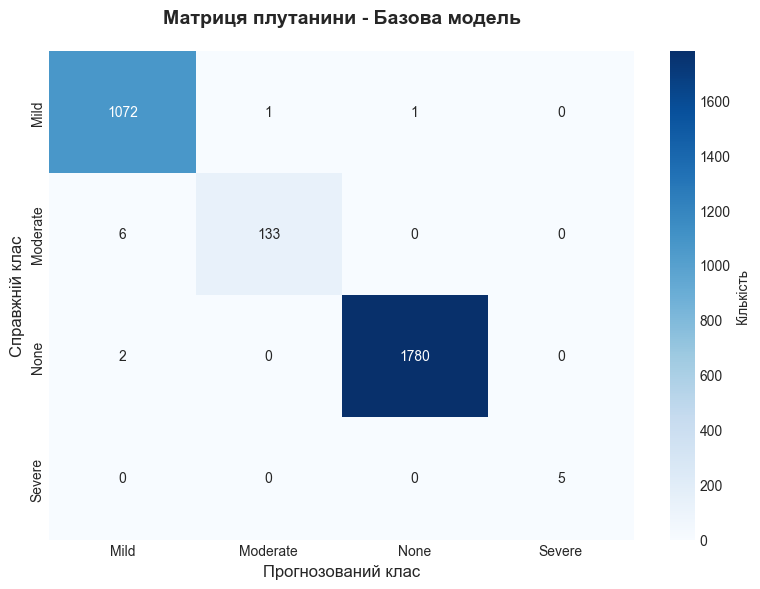

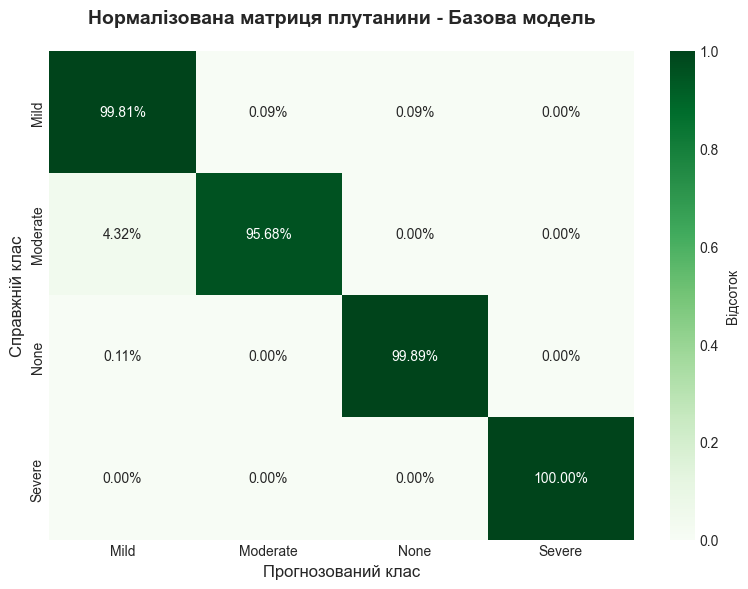

In [129]:
# Матриця плутанини
cm = confusion_matrix(y_test, y_pred_basic)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=target_names, 
            yticklabels=target_names,
            cbar_kws={'label': 'Кількість'})
plt.title('Матриця плутанини - Базова модель', fontsize=14, fontweight='bold', pad=20)
plt.xlabel('Прогнозований клас', fontsize=12)
plt.ylabel('Справжній клас', fontsize=12)
plt.tight_layout()
plt.show()

# Нормалізована матриця плутанини
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(8, 6))
sns.heatmap(cm_norm, annot=True, fmt='.2%', cmap='Greens', 
            xticklabels=target_names, 
            yticklabels=target_names,
            cbar_kws={'label': 'Відсоток'})
plt.title('Нормалізована матриця плутанини - Базова модель', fontsize=14, fontweight='bold', pad=20)
plt.xlabel('Прогнозований клас', fontsize=12)
plt.ylabel('Справжній клас', fontsize=12)
plt.tight_layout()
plt.show()


## Частина 4: Візуалізація Дерева Рішень


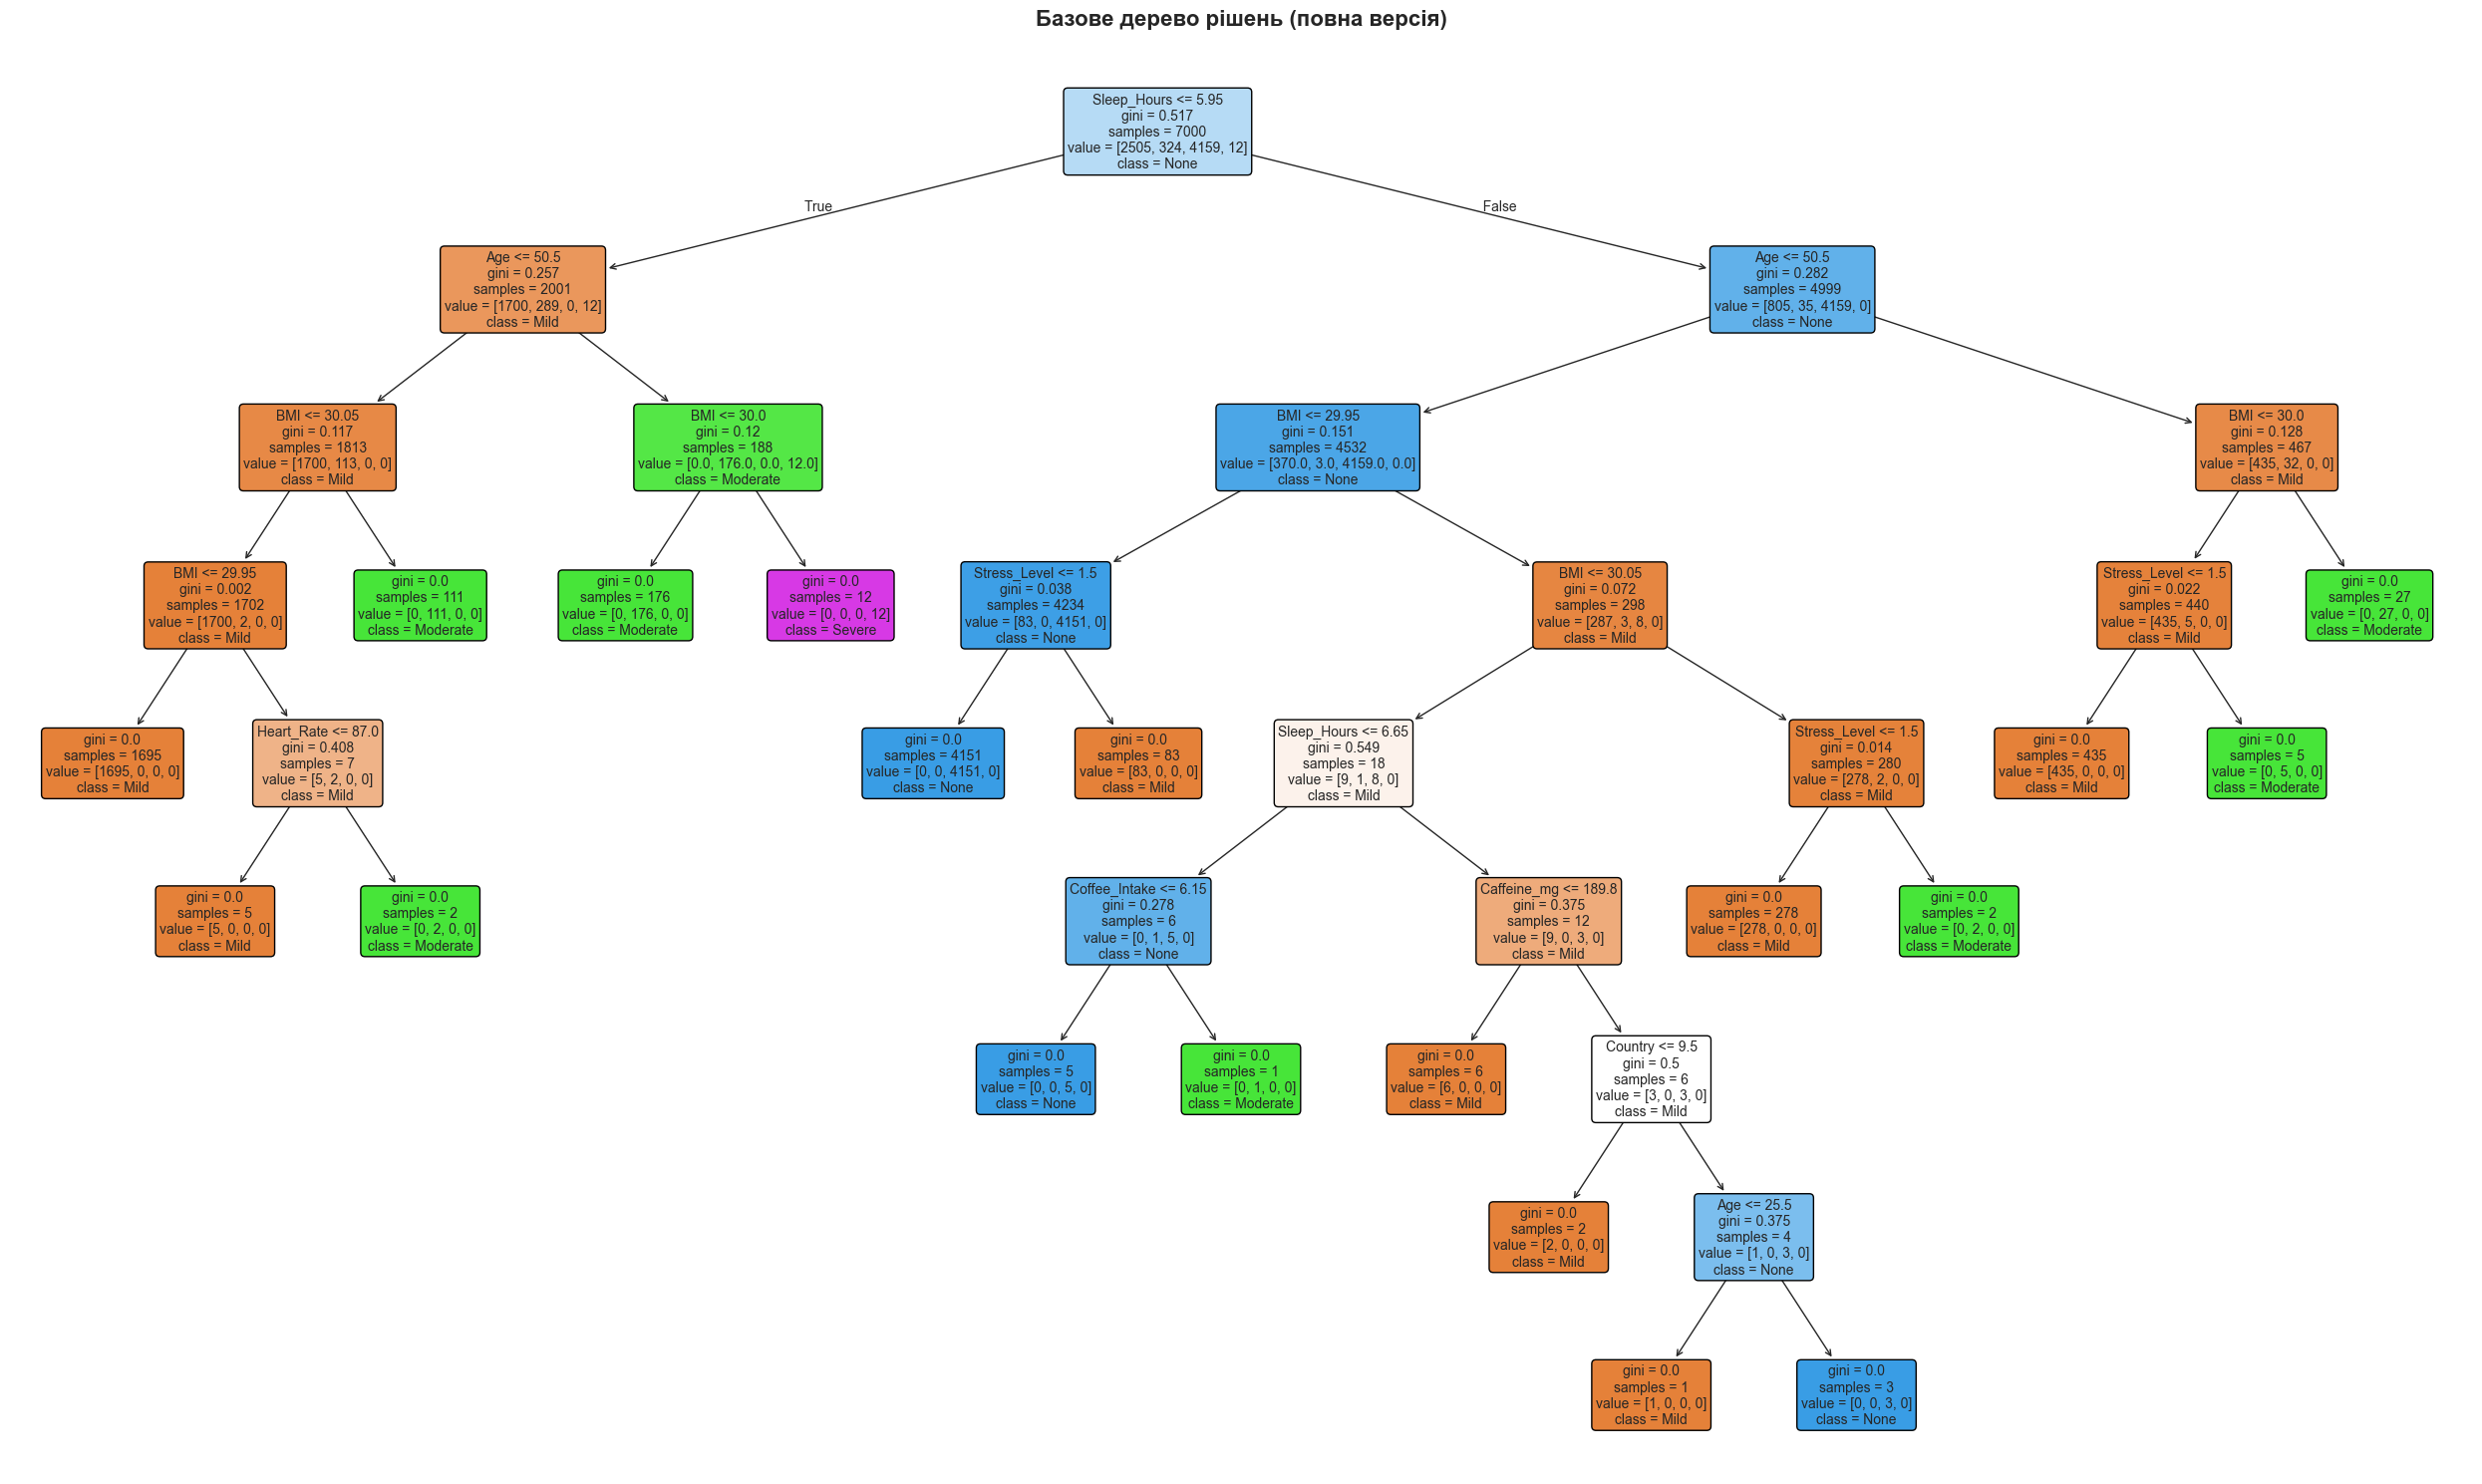

In [130]:
# Візуалізація базового дерева (повна версія)
plt.figure(figsize=(25, 15))
plot_tree(dt_basic, 
          feature_names=feature_names, 
          class_names=target_names,
          filled=True, 
          rounded=True,
          fontsize=10)
plt.title('Базове дерево рішень (повна версія)', fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()


## Частина 5: Важливість Ознак


🎯 Важливість ознак:


,feature,importance
5,Sleep_Hours,0.469203
0,Age,0.261588
7,BMI,0.218310
9,Stress_Level,0.048819
8,Heart_Rate,0.000790
3,Coffee_Intake,0.000461
2,Country,0.000415
4,Caffeine_mg,0.000415
1,Gender,0.000000
6,Sleep_Quality,0.000000


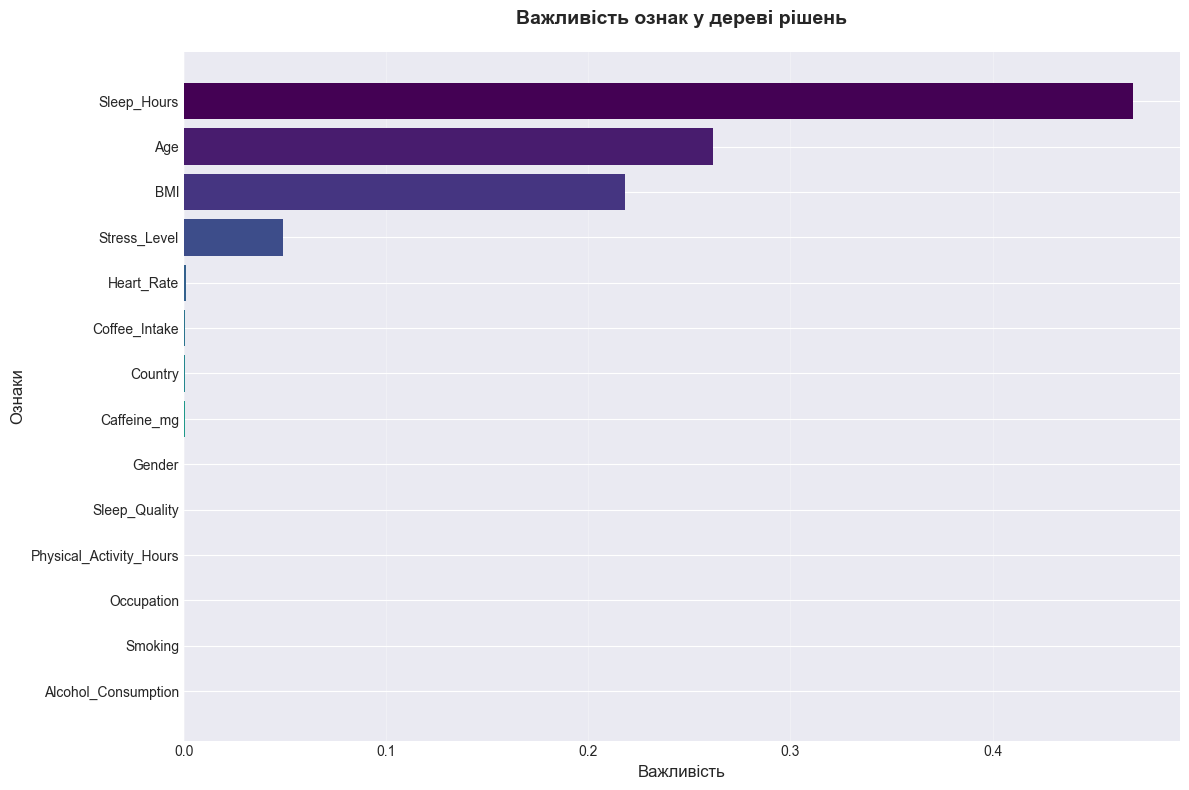

In [132]:
# Важливість ознак
feature_importance = pd.DataFrame({
    'feature': feature_names,
    'importance': dt_basic.feature_importances_
}).sort_values('importance', ascending=False)

print("🎯 Важливість ознак:")
display(feature_importance)

# Візуалізація важливості ознак
plt.figure(figsize=(12, 8))
plt.barh(feature_importance['feature'], feature_importance['importance'], 
         color=plt.cm.viridis(np.linspace(0, 1, len(feature_importance))))
plt.xlabel('Важливість', fontsize=12)
plt.ylabel('Ознаки', fontsize=12)
plt.title('Важливість ознак у дереві рішень', fontsize=14, fontweight='bold', pad=20)
plt.gca().invert_yaxis()
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()


## Частина 6: Оптимізація Гіперпараметрів

### 6.1 Вплив глибини дерева


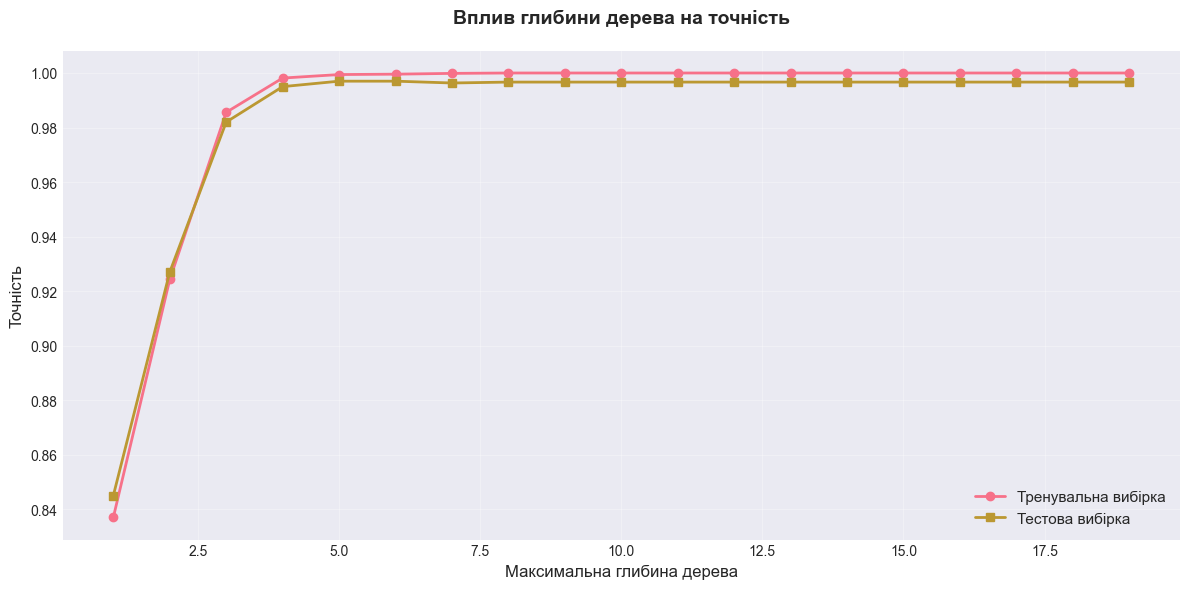


✅ Оптимальна глибина дерева: 5
Максимальна точність на тесті: 0.9970


In [133]:
# Дослідження впливу глибини дерева
max_depths = range(1, 20)
train_scores = []
test_scores = []

for depth in max_depths:
    dt = DecisionTreeClassifier(max_depth=depth, random_state=42)
    dt.fit(X_train, y_train)
    train_scores.append(dt.score(X_train, y_train))
    test_scores.append(dt.score(X_test, y_test))

# Візуалізація
plt.figure(figsize=(12, 6))
plt.plot(max_depths, train_scores, marker='o', label='Тренувальна вибірка', linewidth=2)
plt.plot(max_depths, test_scores, marker='s', label='Тестова вибірка', linewidth=2)
plt.xlabel('Максимальна глибина дерева', fontsize=12)
plt.ylabel('Точність', fontsize=12)
plt.title('Вплив глибини дерева на точність', fontsize=14, fontweight='bold', pad=20)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

optimal_depth = max_depths[np.argmax(test_scores)]
print(f"\n✅ Оптимальна глибина дерева: {optimal_depth}")
print(f"Максимальна точність на тесті: {max(test_scores):.4f}")


### 6.2 Вплив мінімальної кількості зразків для розділення


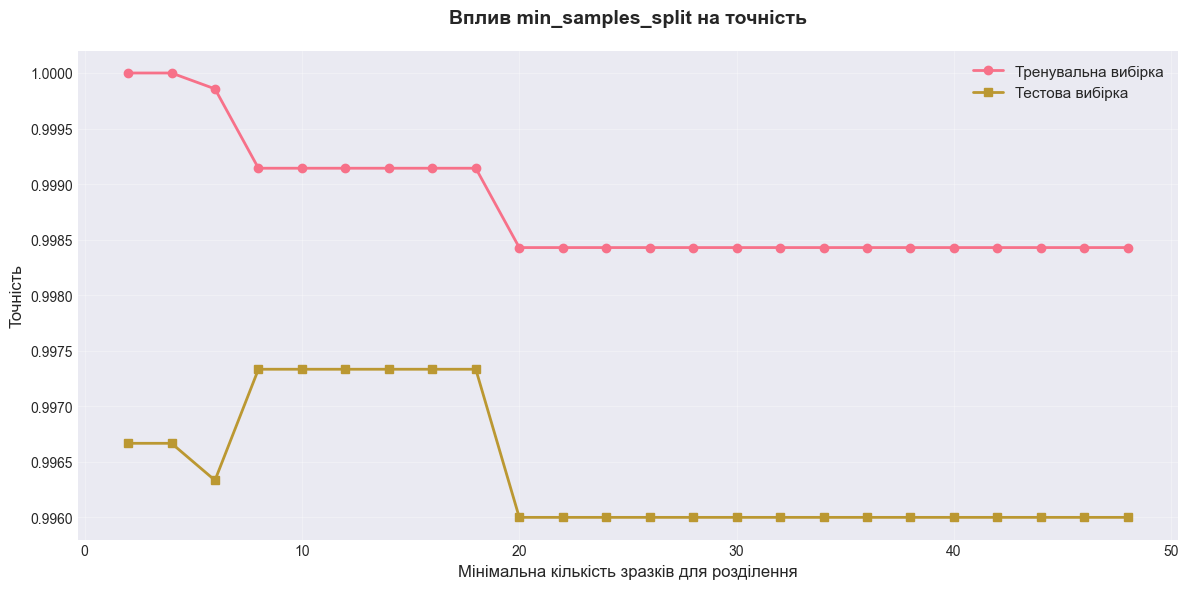


✅ Оптимальне значення min_samples_split: 8
Максимальна точність на тесті: 0.9973


In [134]:
# Дослідження впливу min_samples_split
min_samples_splits = range(2, 50, 2)
train_scores_split = []
test_scores_split = []

for min_split in min_samples_splits:
    dt = DecisionTreeClassifier(min_samples_split=min_split, random_state=42)
    dt.fit(X_train, y_train)
    train_scores_split.append(dt.score(X_train, y_train))
    test_scores_split.append(dt.score(X_test, y_test))

# Візуалізація
plt.figure(figsize=(12, 6))
plt.plot(min_samples_splits, train_scores_split, marker='o', label='Тренувальна вибірка', linewidth=2)
plt.plot(min_samples_splits, test_scores_split, marker='s', label='Тестова вибірка', linewidth=2)
plt.xlabel('Мінімальна кількість зразків для розділення', fontsize=12)
plt.ylabel('Точність', fontsize=12)
plt.title('Вплив min_samples_split на точність', fontsize=14, fontweight='bold', pad=20)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

optimal_split = min_samples_splits[np.argmax(test_scores_split)]
print(f"\n✅ Оптимальне значення min_samples_split: {optimal_split}")
print(f"Максимальна точність на тесті: {max(test_scores_split):.4f}")


### 6.3 Grid Search для оптимізації


In [135]:
# Визначення сітки параметрів
param_grid = {
    'max_depth': [3, 5, 7, 10, 15, None],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 4, 8],
    'criterion': ['gini', 'entropy'],
    'splitter': ['best', 'random']
}

# Grid Search
dt = DecisionTreeClassifier(random_state=42)
grid_search = GridSearchCV(
    estimator=dt,
    param_grid=param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

print("🔍 Початок Grid Search...")
grid_search.fit(X_train, y_train)

print("\n✅ Grid Search завершено!")
print(f"\nНайкращі параметри: {grid_search.best_params_}")
print(f"Найкраща точність (CV): {grid_search.best_score_:.4f}")


🔍 Початок Grid Search...
Fitting 5 folds for each of 384 candidates, totalling 1920 fits

✅ Grid Search завершено!

Найкращі параметри: {'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 10, 'splitter': 'best'}
Найкраща точність (CV): 0.9980


In [136]:
# Оцінка оптимізованої моделі
best_dt = grid_search.best_estimator_
y_pred_best = best_dt.predict(X_test)

print("📊 Оптимізована модель:")
print(f"\nТочність на тестовій вибірці: {accuracy_score(y_test, y_pred_best):.4f}")
print(f"Точність (Precision): {precision_score(y_test, y_pred_best, average='weighted'):.4f}")
print(f"Повнота (Recall): {recall_score(y_test, y_pred_best, average='weighted'):.4f}")
print(f"F1-міра: {f1_score(y_test, y_pred_best, average='weighted'):.4f}")

print(f"\nГлибина оптимізованого дерева: {best_dt.get_depth()}")
print(f"Кількість листів: {best_dt.get_n_leaves()}")

print("\n📋 Детальний звіт:")
print(classification_report(y_test, y_pred_best, target_names=target_names))


📊 Оптимізована модель:

Точність на тестовій вибірці: 0.9973
Точність (Precision): 0.9974
Повнота (Recall): 0.9973
F1-міра: 0.9973

Глибина оптимізованого дерева: 5
Кількість листів: 14

📋 Детальний звіт:
              precision    recall  f1-score   support

        Mild       0.99      1.00      1.00      1074
    Moderate       1.00      0.96      0.98       139
        None       1.00      1.00      1.00      1782
      Severe       1.00      1.00      1.00         5

    accuracy                           1.00      3000
   macro avg       1.00      0.99      0.99      3000
weighted avg       1.00      1.00      1.00      3000



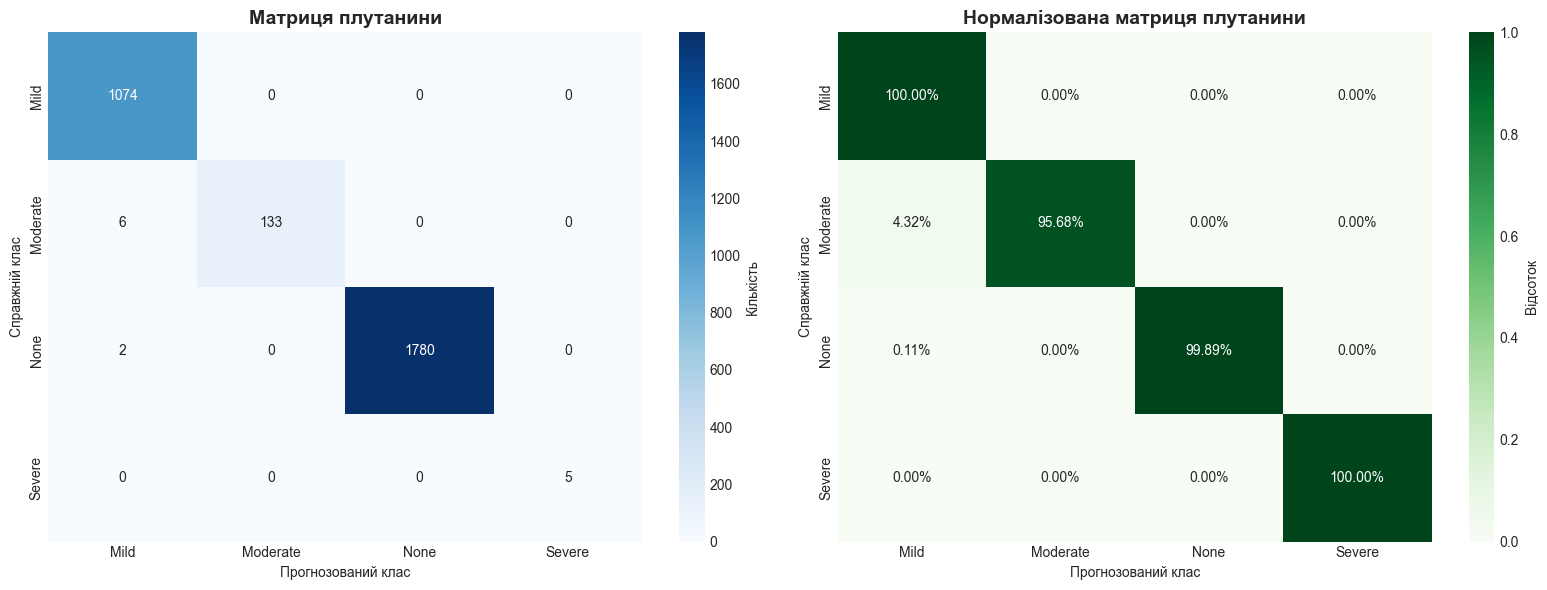

In [137]:
# Матриця плутанини оптимізованої моделі
cm_best = confusion_matrix(y_test, y_pred_best)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Абсолютні значення
sns.heatmap(cm_best, annot=True, fmt='d', cmap='Blues', 
            xticklabels=target_names, 
            yticklabels=target_names,
            ax=axes[0], cbar_kws={'label': 'Кількість'})
axes[0].set_title('Матриця плутанини', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Прогнозований клас')
axes[0].set_ylabel('Справжній клас')

# Нормалізовані значення
cm_best_norm = cm_best.astype('float') / cm_best.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_best_norm, annot=True, fmt='.2%', cmap='Greens', 
            xticklabels=target_names, 
            yticklabels=target_names,
            ax=axes[1], cbar_kws={'label': 'Відсоток'})
axes[1].set_title('Нормалізована матриця плутанини', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Прогнозований клас')
axes[1].set_ylabel('Справжній клас')

plt.tight_layout()
plt.show()


## Частина 7: Порівняння з іншими алгоритмами

### 7.1 Random Forest


In [138]:
# Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

print("🌲 Random Forest:")
print(f"\nТочність: {accuracy_score(y_test, y_pred_rf):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_rf, average='weighted'):.4f}")
print(f"Recall: {recall_score(y_test, y_pred_rf, average='weighted'):.4f}")
print(f"F1-міра: {f1_score(y_test, y_pred_rf, average='weighted'):.4f}")

# Важливість ознак у Random Forest
feature_importance_rf = pd.DataFrame({
    'feature': feature_names,
    'importance': rf.feature_importances_
}).sort_values('importance', ascending=False)

print("\n🎯 Важливість ознак у Random Forest:")
display(feature_importance_rf.head(10))


🌲 Random Forest:

Точність: 0.9957
Precision: 0.9957
Recall: 0.9957
F1-міра: 0.9954

🎯 Важливість ознак у Random Forest:


,feature,importance
5,Sleep_Hours,0.293074
0,Age,0.224342
9,Stress_Level,0.182932
7,BMI,0.156756
6,Sleep_Quality,0.092773
4,Caffeine_mg,0.011491
10,Physical_Activity_Hours,0.009205
8,Heart_Rate,0.007818
3,Coffee_Intake,0.007652
2,Country,0.006240


### 7.2 Gradient Boosting


In [139]:
# Gradient Boosting
gb = GradientBoostingClassifier(n_estimators=100, random_state=42)
gb.fit(X_train, y_train)
y_pred_gb = gb.predict(X_test)

print("🚀 Gradient Boosting:")
print(f"\nТочність: {accuracy_score(y_test, y_pred_gb):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_gb, average='weighted'):.4f}")
print(f"Recall: {recall_score(y_test, y_pred_gb, average='weighted'):.4f}")
print(f"F1-міра: {f1_score(y_test, y_pred_gb, average='weighted'):.4f}")

# Важливість ознак у Gradient Boosting
feature_importance_gb = pd.DataFrame({
    'feature': feature_names,
    'importance': gb.feature_importances_
}).sort_values('importance', ascending=False)

print("\n🎯 Важливість ознак у Gradient Boosting:")
display(feature_importance_gb.head(10))


🚀 Gradient Boosting:

Точність: 0.9960
Precision: 0.9960
Recall: 0.9960
F1-міра: 0.9960

🎯 Важливість ознак у Gradient Boosting:


,feature,importance
5,Sleep_Hours,0.541641
0,Age,0.243788
7,BMI,0.199304
9,Stress_Level,0.010701
6,Sleep_Quality,0.004156
8,Heart_Rate,0.000223
10,Physical_Activity_Hours,0.000084
4,Caffeine_mg,0.000067
3,Coffee_Intake,0.000015
11,Occupation,0.000011


### 7.3 Порівняльна таблиця


In [140]:
# Порівняльна таблиця моделей
models_comparison = pd.DataFrame({
    'Модель': ['Базове дерево', 'Оптимізоване дерево', 'Random Forest', 'Gradient Boosting'],
    'Accuracy': [
        accuracy_score(y_test, y_pred_basic),
        accuracy_score(y_test, y_pred_best),
        accuracy_score(y_test, y_pred_rf),
        accuracy_score(y_test, y_pred_gb)
    ],
    'Precision': [
        precision_score(y_test, y_pred_basic, average='weighted'),
        precision_score(y_test, y_pred_best, average='weighted'),
        precision_score(y_test, y_pred_rf, average='weighted'),
        precision_score(y_test, y_pred_gb, average='weighted')
    ],
    'Recall': [
        recall_score(y_test, y_pred_basic, average='weighted'),
        recall_score(y_test, y_pred_best, average='weighted'),
        recall_score(y_test, y_pred_rf, average='weighted'),
        recall_score(y_test, y_pred_gb, average='weighted')
    ],
    'F1-score': [
        f1_score(y_test, y_pred_basic, average='weighted'),
        f1_score(y_test, y_pred_best, average='weighted'),
        f1_score(y_test, y_pred_rf, average='weighted'),
        f1_score(y_test, y_pred_gb, average='weighted')
    ]
})

print("📊 Порівняння моделей:")
display(models_comparison)

# Знаходження найкращої моделі
best_model_idx = models_comparison['Accuracy'].idxmax()
best_model_name = models_comparison.loc[best_model_idx, 'Модель']
best_model_acc = models_comparison.loc[best_model_idx, 'Accuracy']

print(f"\n🏆 Найкраща модель: {best_model_name} (Accuracy: {best_model_acc:.4f})")


📊 Порівняння моделей:


,Модель,Accuracy,Precision,Recall,F1-score
0,Базове дерево,0.996667,0.996669,0.996667,0.996650
1,Оптимізоване дерево,0.997333,0.997353,0.997333,0.997316
2,Random Forest,0.995667,0.995659,0.995667,0.995441
3,Gradient Boosting,0.996000,0.995998,0.996000,0.995952



🏆 Найкраща модель: Оптимізоване дерево (Accuracy: 0.9973)


## Частина 9: Крос-валідація


In [144]:
# Крос-валідація для різних моделей
models = [
    ('Базове дерево', DecisionTreeClassifier(random_state=42)),
    ('Оптимізоване дерево', best_dt),
    ('Random Forest', RandomForestClassifier(n_estimators=100, random_state=42)),
    ('Gradient Boosting', GradientBoostingClassifier(n_estimators=100, random_state=42))
]

cv_results = []

print("🔄 Виконання крос-валідації...\n")
for name, model in models:
    scores = cross_val_score(model, X, y, cv=5, scoring='accuracy')
    cv_results.append({
        'Модель': name,
        'Середня точність': scores.mean(),
        'Стандартне відхилення': scores.std(),
        'Min': scores.min(),
        'Max': scores.max()
    })
    print(f"{name}:")
    print(f"  Середня точність: {scores.mean():.4f} (+/- {scores.std():.4f})")
    print(f"  Мін: {scores.min():.4f}, Макс: {scores.max():.4f}\n")

cv_df = pd.DataFrame(cv_results)
print("\n📊 Результати крос-валідації:")
display(cv_df)


🔄 Виконання крос-валідації...

Базове дерево:
  Середня точність: 0.9973 (+/- 0.0011)
  Мін: 0.9955, Макс: 0.9985

Оптимізоване дерево:
  Середня точність: 0.9975 (+/- 0.0009)
  Мін: 0.9960, Макс: 0.9985

Random Forest:
  Середня точність: 0.9967 (+/- 0.0009)
  Мін: 0.9950, Макс: 0.9975

Gradient Boosting:
  Середня точність: 0.9981 (+/- 0.0013)
  Мін: 0.9960, Макс: 0.9995


📊 Результати крос-валідації:


,Модель,Середня точність,Стандартне відхилення,Min,Max
0,Базове дерево,0.9973,0.001122,0.9955,0.9985
1,Оптимізоване дерево,0.9975,0.000894,0.9960,0.9985
2,Random Forest,0.9967,0.000927,0.9950,0.9975
3,Gradient Boosting,0.9981,0.001319,0.9960,0.9995
